In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import logging
import sys, os

from scipy.stats.mstats import winsorize
from scipy.stats import shapiro, mannwhitneyu, pointbiserialr

from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, make_scorer,
                             f1_score, roc_auc_score, auc, roc_curve, r2_score, mean_squared_error)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier          
from sklearn.pipeline import Pipeline    
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.feature_selection import mutual_info_classif

import shap
import pymc as pm
import arviz as az

import xgboost as xgb

from src.preprocessing import winsorize_columns
import backtest

/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams["font.family"] = "Helvetica"  

sns.set_style("whitegrid")

In [3]:
# Add src/ to the Python path
sys.path.append(os.path.join(os.getcwd(), "src"))
from main import preprocess
# Run the preprocessing pipeline and get final DataFrame
final_df = preprocess()
final_df.head()

/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/arshsingh/Documents/Montclair/portfolio-masters-capstone/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Unnamed: 0.1,Unnamed: 0,date_x,symbol_fin,reportedCurrency_x,cik_x,fillingDate_x,acceptedDate,calendarYear_x,period_x,...,rnd_to_revenue_roll8,inventory_to_assets_roll4,inventory_to_assets_roll8,future_date,future_price,future_dji,log_dji_return,log_return_future,relative_log_return,good_stock
0,63111,75310,1999-12-31,DOX,USD,1062579.0,2000-01-05,2000-01-05,2000,Q1,...,0.063694,0.000000,0.000000,2000-06-08,58.586189,1461.670044,0.041601,0.715895,0.674294,1
1,130799,153831,1999-11-25,MCS,USD,62234.0,2000-01-07,2000-01-07,1999,Q4,...,0.000000,0.000000,0.000000,2000-04-07,4.356047,1516.349976,0.050643,-0.240857,-0.291499,0
2,141749,166758,1999-11-30,MTRX,USD,866273.0,2000-01-13,2000-01-13,2000,Q2,...,0.000000,0.035111,0.035111,2000-04-13,2.437500,1440.510010,-0.006346,-0.248461,-0.242116,0
3,188722,222772,1999-11-30,SKY,USD,90896.0,2000-01-13,2000-01-13,1999,Q3,...,0.000000,0.044463,0.044463,2000-08-04,13.072436,1462.930054,0.009098,-0.197612,-0.206711,0
4,196657,232068,1999-11-30,STRL,USD,874238.0,2000-01-14,2000-01-14,1999,Q4,...,0.000000,0.267070,0.267070,2000-07-19,1.187500,1481.959961,0.011408,-0.051293,-0.062701,0


In [4]:
# Additional ratios after netChangeInCash and netCashUsedProvidedByFinancingActivities were highlighted as important in the importance analysis
final_df['netChangeInCash_to_TotalAssets'] = final_df['netChangeInCash'] / final_df['totalAssets']
final_df['netChangeInCash_to_OpCashFlow'] = final_df['netChangeInCash'] / final_df['operatingCashFlow']
final_df['netChangeInCash_to_Revenue'] = final_df['netChangeInCash'] / final_df['revenue']

final_df['netCashFinancing_to_TotalDebt'] = final_df['netCashUsedProvidedByFinancingActivities'] / final_df['totalDebt']
final_df['netCashFinancing_to_Equity'] = final_df['netCashUsedProvidedByFinancingActivities'] / final_df['totalEquity']
final_df['netCashFinancing_to_OpCashFlow'] = final_df['netCashUsedProvidedByFinancingActivities'] / final_df['operatingCashFlow']
final_df['netCashFinancing_to_Revenue'] = final_df['netCashUsedProvidedByFinancingActivities'] / final_df['revenue']

2025-04-19 18:46:16,405 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-19 18:46:16,453 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


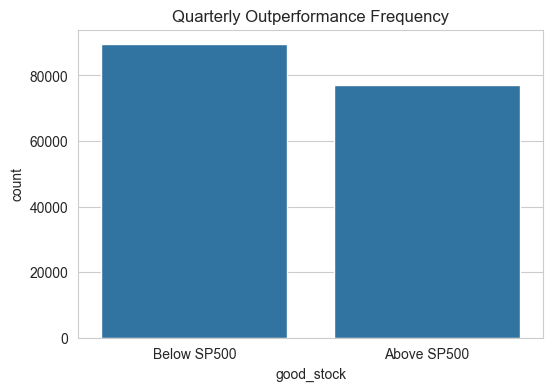

good_stock
0    0.537659
1    0.462341
Name: proportion, dtype: float64


In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='good_stock', data=final_df)
plt.xticks([0,1], ['Below SP500','Above SP500'])
plt.title("Quarterly Outperformance Frequency")
plt.show()

print(final_df['good_stock'].value_counts(normalize=True))

The breakdown of the classes is roughly similar. This is good to see as the class imbalance might lead to issues during modeling. The slight majority underperforming is explained by the fact that the threshold is 0.02 above SP500 instead of 0.00.

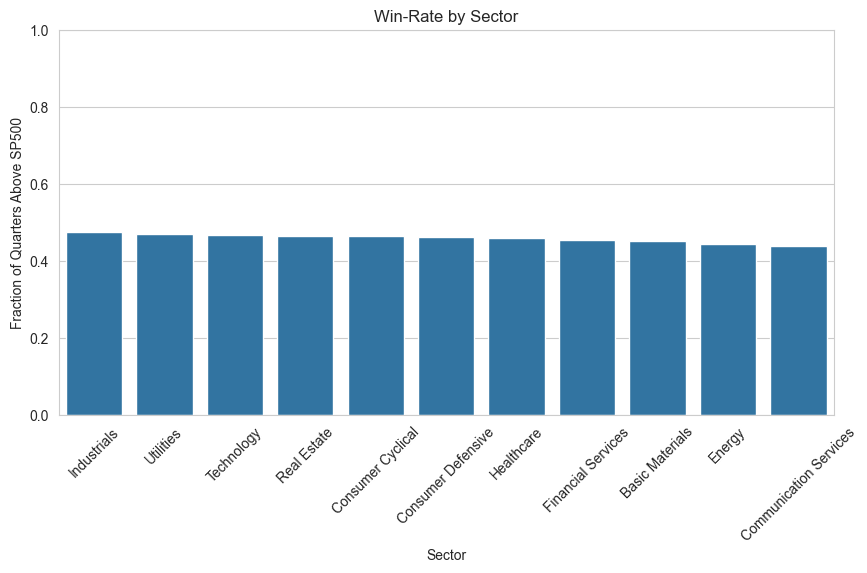

In [6]:
plt.figure(figsize=(10,5))
# Compute fraction of winners per sector
frac = (final_df
        .groupby('Sector')['good_stock']
        .mean()
        .sort_values(ascending=False)
        .reset_index())

sns.barplot(x='Sector', y='good_stock', data=frac)
plt.xticks(rotation=45)
plt.ylabel("Fraction of Quarters Above SP500")
plt.title("Win-Rate by Sector")
plt.ylim(0,1)
plt.show()

/var/folders/qt/m1d2k3qd4_z368vlhrz0r7w80000gn/T/ipykernel_45737/1654350059.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


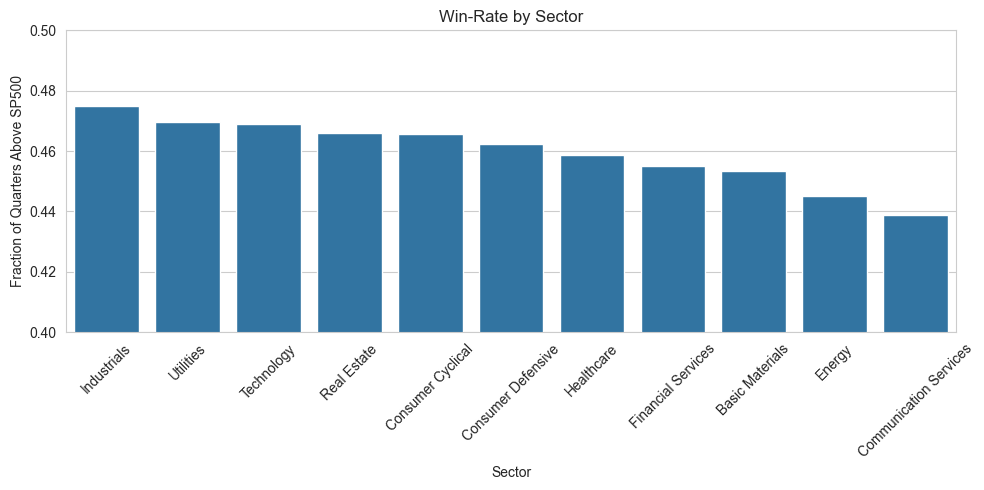

In [14]:
plt.figure(figsize=(10,5))

frac = (final_df
        .groupby('Sector')['good_stock']
        .mean()
        .sort_values(ascending=False)
        .reset_index())

ax = sns.barplot(x='Sector', y='good_stock', data=frac)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Fraction of Quarters Above SP500")
ax.set_title("Win-Rate by Sector")

# Adjust y-axis limit to identify differences between Sector performance more closely
ax.set_ylim(0.40, 0.50)

plt.tight_layout()
plt.show()

In a slightly surprising outcome, the performances are roughly similar by sector. Sectors, especially outside of Energy and Communication Services, perform about the same. This can possibly assist in diversification strategy. Energy is volatile, so this may be a sector to consider for threshold adjustment, where the model has to have higher confidence of a higher stock for it to receive the predicted signal to buy.